## Import Packages

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, f1_score, accuracy_score, recall_score, precision_score

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score

import pickle

In [ ]:
# Checking Requirements for Deployment

In [ ]:
import pandas
print(pandas.__version__)

In [ ]:
import numpy
print(numpy.__version__)

In [ ]:
!python --version

In [ ]:
!pip show scikit-learn

#### Export Requirements

In [ ]:
!pip3 freeze | grep '==' > requirements.txt

## DATA - Exploring & Cleaning

In [2]:
# import data: CHLA_DATA.csv
df = pd.read_csv('CHLA_DATA.csv')

In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
# look at the data types
df.dtypes

In [3]:
# check for duplicates
df.duplicated().sum()

4

In [4]:
# delete duplicates
df = df.drop_duplicates()

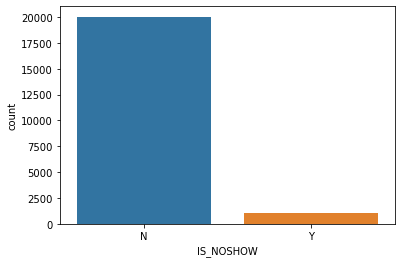

IS_NOSHOW
N    20023
Y     1033
Name: count, dtype: int64
IS_NOSHOW
N    95.094035
Y     4.905965
Name: proportion, dtype: float64


In [5]:
# plot the distribution of the target variable: IS_NOSHOW
sns.countplot(x='IS_NOSHOW', data=df)
plt.show()

# show the count and percentage of each class
print(df['IS_NOSHOW'].value_counts())
print(df['IS_NOSHOW'].value_counts(normalize=True) * 100)

In [6]:
# show no. of unique values for each categorical column
df.select_dtypes(include='object').nunique()

APPT_STATUS                  7
APPT_DATE                11296
BOOK_DATE                15770
ZIPCODE                    598
CLINIC                       6
IS_REPEAT                    2
APPT_TYPE_STANDARDIZE        3
IS_NOSHOW                    2
ETHNICITY_STANDARDIZE        3
RACE_STANDARDIZE             7
dtype: int64

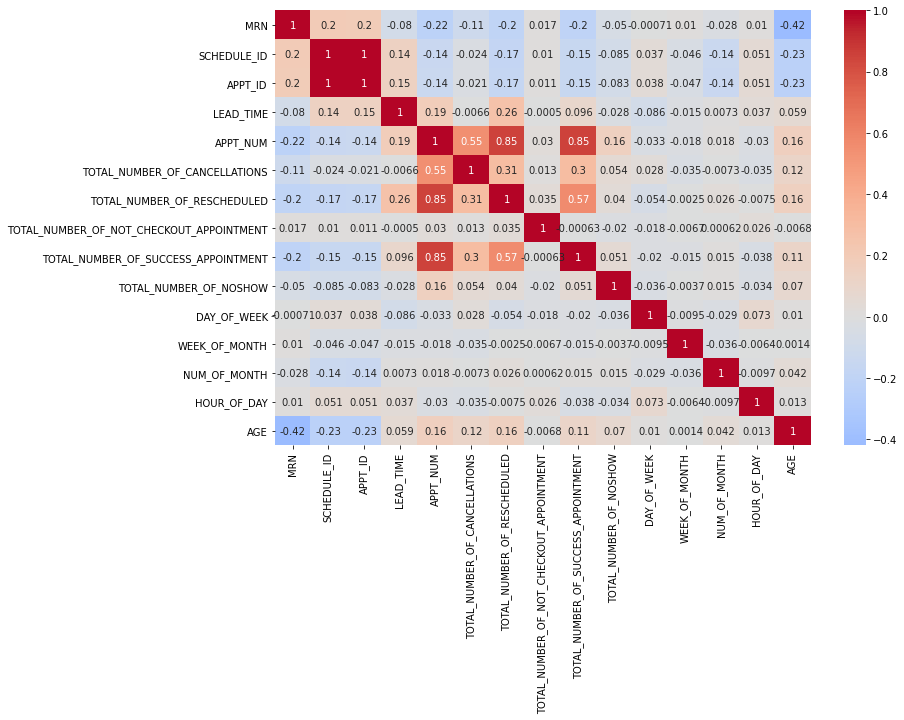

In [7]:
# select numerical columns
num_cols = df.select_dtypes(include='number').columns.tolist()

# make correlation matrix chart for numerical columns only
plt.figure(figsize=(12, 8))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.show()

## Feature Selection & Encoding

In [8]:
# manually dropping columns based on EDA and domain knowledge

# drop APPT_STATUS column because it gives the answer to the target variable
df = df.drop(columns=['APPT_STATUS'])

# drop identifier columns (irrelevant): MRN, APPT_ID, SCHEDULE_ID
df = df.drop(columns=['MRN', 'APPT_ID', 'SCHEDULE_ID'])

In [9]:
# show no. of unique values for each categorical column
df.select_dtypes(include='object').nunique()

APPT_DATE                11296
BOOK_DATE                15770
ZIPCODE                    598
CLINIC                       6
IS_REPEAT                    2
APPT_TYPE_STANDARDIZE        3
IS_NOSHOW                    2
ETHNICITY_STANDARDIZE        3
RACE_STANDARDIZE             7
dtype: int64

In [10]:
cat_cols = df.select_dtypes(include=['object']).columns
cat_cols

Index(['APPT_DATE', 'BOOK_DATE', 'ZIPCODE', 'CLINIC', 'IS_REPEAT',
       'APPT_TYPE_STANDARDIZE', 'IS_NOSHOW', 'ETHNICITY_STANDARDIZE',
       'RACE_STANDARDIZE'],
      dtype='object')

In [11]:
# Convert 'IS_NOSHOW' and 'IS_REPEAT' from 'Y'/'N' to 1/0
df['IS_NOSHOW'] = df['IS_NOSHOW'].map({'Y': 1, 'N': 0})
df['IS_REPEAT'] = df['IS_REPEAT'].map({'Y': 1, 'N': 0})

In [77]:
# LABEL ENCODING (used for tree-based models)

lbl_data = df.copy()

# List of categorical columns to encode
category_col = ['APPT_DATE', 'BOOK_DATE', 'ZIPCODE', 'CLINIC', 'APPT_TYPE_STANDARDIZE',
       'ETHNICITY_STANDARDIZE', 'RACE_STANDARDIZE']


df_input = df[category_col].copy()
encoder_dict = dict()

for cat in category_col:
    # Ensure all data is treated as string and strip leading spaces to ensure consistent encoding
    df_input[cat] = df_input[cat].astype(str).str.lstrip()
    # Initialize the LabelEncoder
    enc = preprocessing.LabelEncoder()
    # Fit the encoder including an 'Unknown' category
    enc.fit(list(df_input[cat]) + ['Unknown'])
    # Store the encoder classes for each category
    encoder_dict[cat] = enc.classes_
    # Transform and encode the data
    lbl_data[cat] = enc.transform(df_input[cat])

# Verify the changes
print(lbl_data.head())

KeyError: "['APPT_DATE'] not in index"

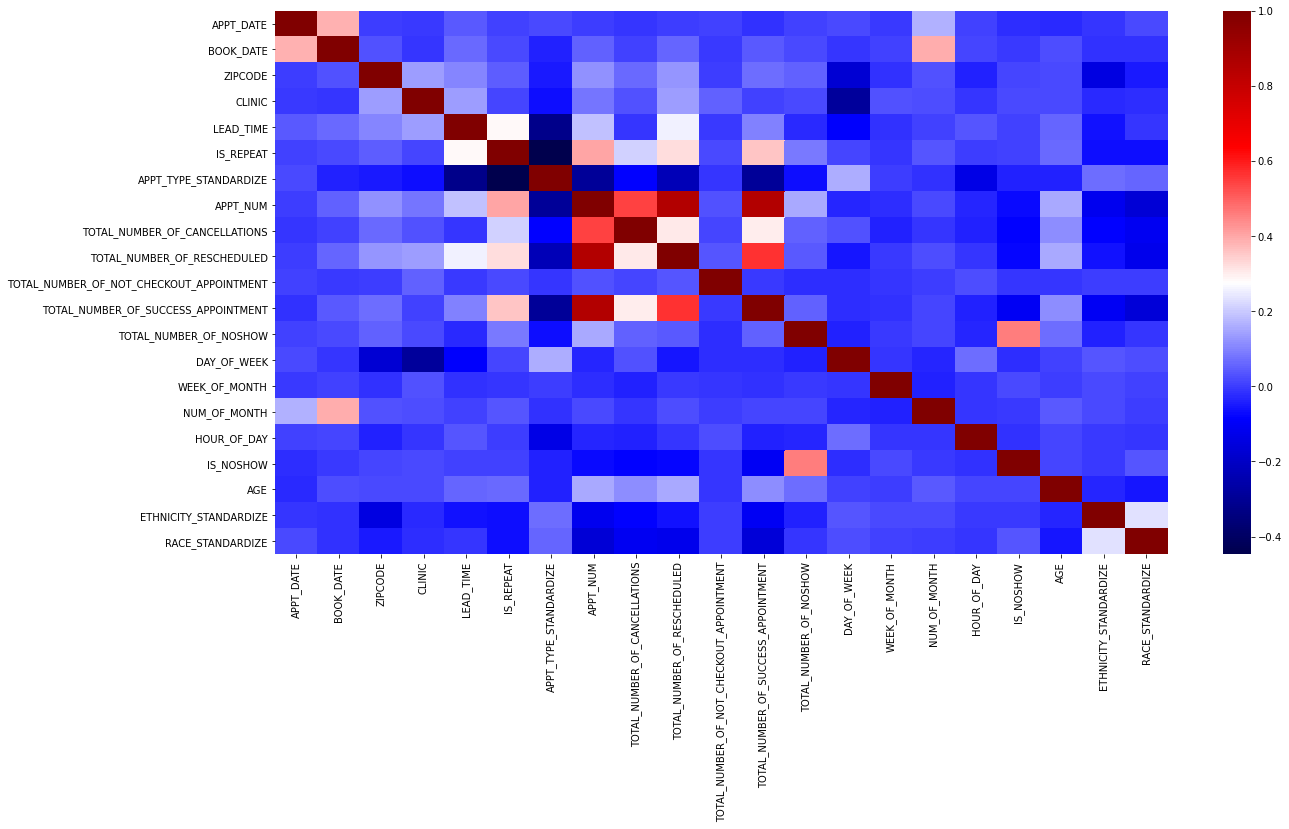

In [13]:
# Heatmap to find any high correlations
plt.figure(figsize=(20,10))
sns.heatmap(data=lbl_data.corr(), cmap="seismic")
plt.show()

# Save Encoder

In [14]:
encoder_pickle_out = open("encoder.pkl", "wb")
pickle.dump(encoder_dict, encoder_pickle_out)
encoder_pickle_out.close()

## Label and Split

In [15]:
# split the data into train and test sets
X = lbl_data.drop('IS_NOSHOW', axis = 1) 
Y = lbl_data['IS_NOSHOW']

In [16]:
# UNDER SAMPLING the target variable
from imblearn.under_sampling import RandomUnderSampler

# Initialize the RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Resample the dataset
X_res, Y_res = rus.fit_resample(X, Y)

# Now, X_res and Y_res contain the undersampled dataset

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_res, Y_res, test_size=0.3, random_state=100)

## Model 1 - Random Forest Classifier

In [18]:
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train.values, y_train)
ypred = rf.predict(X_test.values)
print(confusion_matrix(y_test, ypred))
print(classification_report(y_test, ypred))
print("Accuracy Score:", accuracy_score(y_test, ypred))
print("Recall Score:", recall_score(y_test, ypred))
print("Precision Score:", precision_score(y_test, ypred))
print("ROC AUC Score: ", roc_auc_score(y_test, ypred))
rf_fp, rf_tp, rf_threshold = roc_curve(y_test, ypred)
print("Threshold:", rf_threshold)

[[266  49]
 [  7 298]]
              precision    recall  f1-score   support

           0       0.97      0.84      0.90       315
           1       0.86      0.98      0.91       305

    accuracy                           0.91       620
   macro avg       0.92      0.91      0.91       620
weighted avg       0.92      0.91      0.91       620

Accuracy Score: 0.9096774193548387
Recall Score: 0.9770491803278688
Precision Score: 0.8587896253602305
ROC AUC Score:  0.9107468123861565
Threshold: [inf  1.  0.]


In [19]:
feature_importance_df = pd.DataFrame(X_train.columns, columns=["Feature"])
feature_importance_df["Importance"] = rf.feature_importances_
feature_importance_df.sort_values('Importance', ascending=False, inplace=True)
feature_importance_df = feature_importance_df.head(20)
feature_importance_df

,Feature,Importance
12,TOTAL_NUMBER_OF_NOSHOW,0.574319
4,LEAD_TIME,0.050954
11,TOTAL_NUMBER_OF_SUCCESS_APPOINTMENT,0.049287
0,APPT_DATE,0.034317
8,TOTAL_NUMBER_OF_CANCELLATIONS,0.033178
1,BOOK_DATE,0.032995
7,APPT_NUM,0.030453
2,ZIPCODE,0.026488
17,AGE,0.024180
9,TOTAL_NUMBER_OF_RESCHEDULED,0.023908


Text(0.5, 1.0, 'Plot Feature Importances')

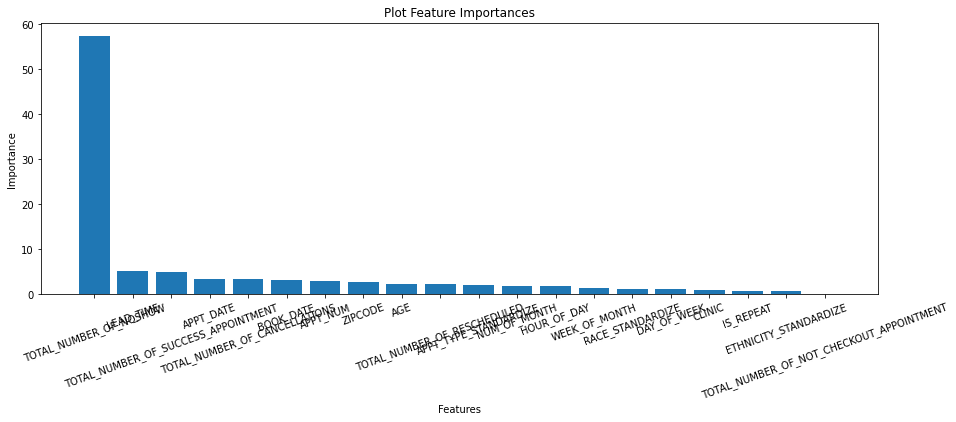

In [20]:
plt.figure(figsize=(15,5))
ax = feature_importance_df['Feature']
plt.bar(range(feature_importance_df.shape[0]), feature_importance_df['Importance']*100)
plt.xticks(range(feature_importance_df.shape[0]), feature_importance_df['Feature'], rotation = 20)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Plot Feature Importances")

# Model 2 - Gradient Boost Classifier

In [22]:
gbc = GradientBoostingClassifier(n_estimators=100, random_state=0)
gbc.fit(X_train, y_train)
ypred = gbc.predict(X_test)
print(confusion_matrix(y_test, ypred))
print(classification_report(y_test, ypred))
print("Accuracy Score:", accuracy_score(y_test, ypred))
print("Recall Score:", recall_score(y_test, ypred))
print("Precision Score:", precision_score(y_test, ypred))
print("ROC AUC Score: ", roc_auc_score(y_test, ypred))
gbc_fp, gbc_tp, gbc_threshold = roc_curve(y_test, ypred)
print("Threshold:", gbc_threshold)

[[264  51]
 [  9 296]]
              precision    recall  f1-score   support

           0       0.97      0.84      0.90       315
           1       0.85      0.97      0.91       305

    accuracy                           0.90       620
   macro avg       0.91      0.90      0.90       620
weighted avg       0.91      0.90      0.90       620

Accuracy Score: 0.9032258064516129
Recall Score: 0.9704918032786886
Precision Score: 0.8530259365994236
ROC AUC Score:  0.9042935206869633
Threshold: [inf  1.  0.]


# Model 3 - AdaBoost Classifier

In [23]:
abc = AdaBoostClassifier(n_estimators=100, random_state=0)
abc.fit(X_train, y_train)
ypred = abc.predict(X_test)
print(confusion_matrix(y_test, ypred))
print(classification_report(y_test, ypred))
print("Accuracy Score:", accuracy_score(y_test, ypred))
print("Recall Score:", recall_score(y_test, ypred))
print("Precision Score:", precision_score(y_test, ypred))
print("ROC AUC Score: ", roc_auc_score(y_test, ypred))
abc_fp, abc_tp, abc_threshold = roc_curve(y_test, ypred)
print("Threshold:", abc_threshold)

[[269  46]
 [ 20 285]]
              precision    recall  f1-score   support

           0       0.93      0.85      0.89       315
           1       0.86      0.93      0.90       305

    accuracy                           0.89       620
   macro avg       0.90      0.89      0.89       620
weighted avg       0.90      0.89      0.89       620

Accuracy Score: 0.8935483870967742
Recall Score: 0.9344262295081968
Precision Score: 0.8610271903323263
ROC AUC Score:  0.8941972417382252
Threshold: [inf  1.  0.]


# ROC Curve

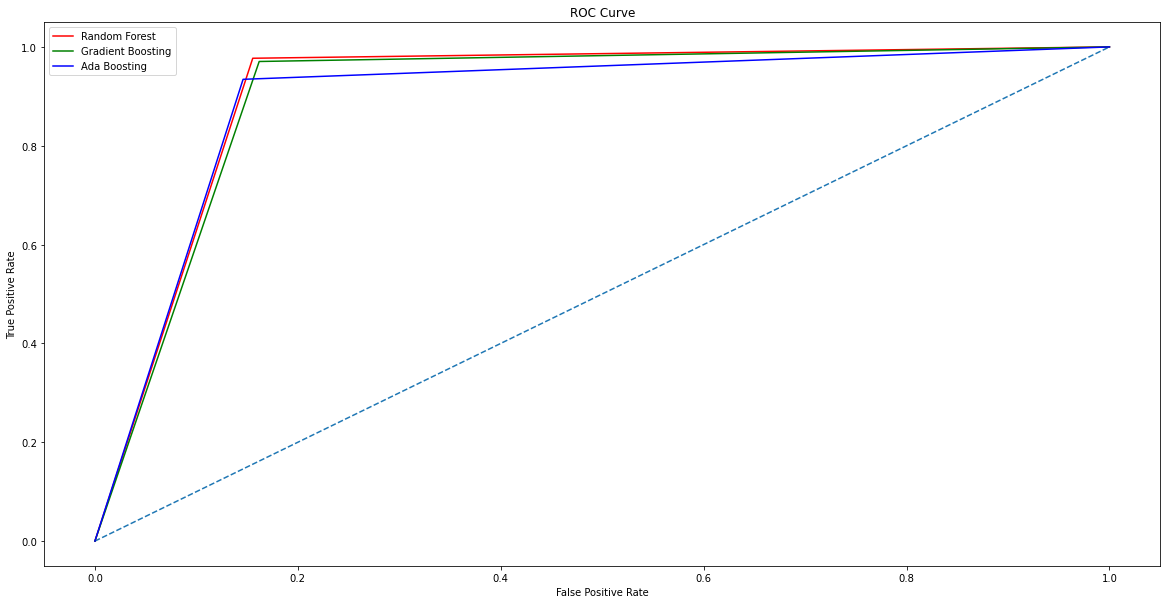

In [24]:
plt.figure(figsize=(20,10))
plt.plot([0, 1], [0, 1], linestyle = "--")
plt.plot(rf_fp, rf_tp, color="red", label = "Random Forest")
plt.plot(gbc_fp, gbc_tp, color="green", label = "Gradient Boosting")
plt.plot(abc_fp, abc_tp, color="blue", label = "Ada Boosting")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

# Further Automated Feature Selection
Given the ROC and the corresponding AUC, we will continue feature selection given that our best model was Random Forest.

In [ ]:
# Define the range of number of features to test
n_features_to_test = range(1, X_train.shape[1])

# Initialize a dictionary to hold the results
auc_scores = {}

for n_features in n_features_to_test:
    # Set up SequentialFeatureSelector with X_train and y_train
    sfs = SequentialFeatureSelector(rf, n_features_to_select=n_features, direction='forward')
    sfs.fit(X_train, y_train)

    # Transform the dataset to the selected features
    X_selected_train = sfs.transform(X_train)
    X_selected_test = sfs.transform(X_test)
    
    # Evaluate the model's performance with cross-validation using the training data
    auc_score = cross_val_score(rf, X_selected_train, y_train, cv=5, scoring='roc_auc').mean()
    
    # Store the AUC score with the corresponding number of features
    auc_scores[n_features] = auc_score

    # Optionally, print the results for each number of features
    print(f"Number of Features: {n_features}, AUC: {auc_score:.4f}")

# Find the number of features with the best AUC score
best_n_features = max(auc_scores, key=auc_scores.get)
best_auc_score = auc_scores[best_n_features]

# Perform SFS with the best number of features on the entire dataset (optional or according to specific use case)
best_sfs = SequentialFeatureSelector(rf, n_features_to_select=best_n_features, direction='forward')
best_sfs.fit(X_train, y_train)

# Get the best feature names
best_feature_idx = best_sfs.get_support()
best_feature_names = X_train.columns[best_feature_idx]

print(f"Best Number of Features: {best_n_features}, AUC: {best_auc_score:.4f}")
print(f"Selected Features: {best_feature_names}")

In [ ]:
# Assuming auc_scores is a dictionary with number of features as keys and AUC scores as values
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(list(auc_scores.keys()), list(auc_scores.values()), marker='o', linestyle='-', color='b')
plt.title('Feature Selection: Number of Features vs. AUC Score')
plt.xlabel('Number of Features')
plt.ylabel('AUC Score')
plt.grid(True)
plt.xticks(list(auc_scores.keys())) # Ensure x-ticks match the number of features tested
plt.show()

In [48]:
sfs = SequentialFeatureSelector(rf, n_features_to_select=13, direction='forward')
sfs.fit(X_train, y_train)

# Transform the dataset to the selected features
X_selected = sfs.transform(X_train)

# Get the mask of selected features
feature_idx = sfs.get_support()
# Get the feature names
feature_names = X_train.columns[feature_idx]

print("Selected Features:", feature_names)

Selected Features: Index(['BOOK_DATE', 'ZIPCODE', 'CLINIC', 'LEAD_TIME', 'IS_REPEAT',
       'APPT_TYPE_STANDARDIZE', 'TOTAL_NUMBER_OF_NOT_CHECKOUT_APPOINTMENT',
       'TOTAL_NUMBER_OF_SUCCESS_APPOINTMENT', 'TOTAL_NUMBER_OF_NOSHOW',
       'DAY_OF_WEEK', 'WEEK_OF_MONTH', 'ETHNICITY_STANDARDIZE',
       'RACE_STANDARDIZE'],
      dtype='object')


In [62]:
# Narrow down the datasets to the selected features
X_train_selected = X_train.loc[:, sfs.get_support()]
X_test_selected = X_test.loc[:, sfs.get_support()]

# Retrain the model
rf_selected = RandomForestClassifier(n_estimators=100, random_state=0)
rf_selected.fit(X_train_selected, y_train)

# Predict on the test set
y_pred = rf_selected.predict(X_test_selected)
y_pred_proba = rf_selected.predict_proba(X_test_selected)[:, 1]

# Generate various evaluation metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_pred_proba)

# Generate ROC curve values
rf_fp, rf_tp, rf_thresholds = roc_curve(y_test, y_pred_proba)

# Print out the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(f"Accuracy Score: {test_accuracy}")
print(f"Recall Score: {test_recall}")
print(f"Precision Score: {test_precision}")
print(f"ROC AUC Score: {test_auc}")

[[263  52]
 [  5 300]]
              precision    recall  f1-score   support

           0       0.98      0.83      0.90       315
           1       0.85      0.98      0.91       305

    accuracy                           0.91       620
   macro avg       0.92      0.91      0.91       620
weighted avg       0.92      0.91      0.91       620

Accuracy Score: 0.9080645161290323
Recall Score: 0.9836065573770492
Precision Score: 0.8522727272727273
ROC AUC Score: 0.9479625292740046


# Save Model

In [37]:
pickle_out = open("model.pkl", "wb")
pickle.dump(rf_selected, pickle_out)
pickle_out.close()

# Test Model

In [38]:
pkl_file = open('encoder.pkl', 'rb')
encoder_dict_V2 = pickle.load(pkl_file) 
pkl_file.close()

#encoder_dict

In [43]:
# example input

data = { 
    'BOOK_DATE':'2/13/18 17:14', 
    'ZIPCODE':90403, 
    'CLINIC':'SANTA MONICA CLINIC', 
    'LEAD_TIME': 60, 
    'IS_REPEAT':'Y', 
    'APPT_TYPE_STANDARDIZE':'Follow-up', 
    'TOTAL_NUMBER_OF_NOT_CHECKOUT_APPOINTMENT':0,
    'TOTAL_NUMBER_OF_SUCCESS_APPOINTMENT':4, 
    'TOTAL_NUMBER_OF_NOSHOW':1,
    'DAY_OF_WEEK':2, 
    'WEEK_OF_MONTH':3, 
    'ETHNICITY_STANDARDIZE':'Hispanic', 
    'RACE_STANDARDIZE':'European',
       }

# Convert the data into a DataFrame for easier manipulation
df = pd.DataFrame([data])

# Load the encoder dictionary from a pickle file
with open('encoder.pkl', 'rb') as pkl_file:
    encoder_dict = pickle.load(pkl_file)


# Preprocess and encode the categorical columns
category_col = ['BOOK_DATE', 'ZIPCODE', 'CLINIC', 'APPT_TYPE_STANDARDIZE',
       'ETHNICITY_STANDARDIZE', 'RACE_STANDARDIZE']

for col in category_col:
    # Initialize a LabelEncoder
    le = preprocessing.LabelEncoder()
    
    # Convert the loaded classes list to a numpy array with dtype 'object'
    le.classes_ = np.array(encoder_dict[col], dtype=object)

    # Check and replace unknown values with 'Unknown'
    df[col] = df[col].apply(lambda x: x if x in le.classes_ else 'Unknown')
    
    # If 'Unknown' is not in le.classes_, add it or handle accordingly
    if 'Unknown' not in le.classes_:
        print(f"'Unknown' category not handled for {col}.")
        continue
    
    # Transform the data
    df[col] = le.transform(df[col])

# Add manual mapping here
manual_mappings = {'IS_REPEAT': {'Y': 1, 'N': 0}}

for col, mapping in manual_mappings.items():
    # Apply the mapping
    df[col] = df[col].map(mapping)


In [69]:
# Prediction Section
model = pickle.load(open('model.pkl', 'rb'))
prediction = model.predict(df)
print(prediction[0])

1


In [ ]:
### LOCAL DEPLOYMENT

In [ ]:
!streamlit run app.py


  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://192.168.1.93:8501

/Users/xiomara/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
2024-03-17 18:26:49.037 Uncaught app exception
Traceback (most recent call last):
  File "/Users/xiomara/opt/anaconda3/lib/python3.8/site-packages/streamlit/runtime/scriptrunner/script_runner.py", line 535, in _run_script
    exec(code, module.__dict__)
  File "/Users/xiomara/Desktop/BSAN 6198/Project 2/vish/Feature Selection/app.py", line 171, in <module>
    main()
  File "/Users/xiomara/Desktop/BSAN 6198/Project 2/vish/Feature Selection/app.py", line 158, in main
    prediction = model.predict(features_list)
  File "/Users/xiomara/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 823, in predict
    proba = self.predict_proba(X

/Users/xiomara/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/xiomara/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/xiomara/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/xiomara/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/xiomara/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warni

In [ ]:
!pip install streamlit